In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import progressbar
from scipy import stats
sns.set()

%matplotlib inline

# Define path and load files 

Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [2]:
data = "../Data"
resultpath = '../Results'
PPI_ID = "2018_08"

In [3]:
G = nx.read_graphml(os.path.join(data, 'PPIs', 'PPI_{}.graphml'.format(PPI_ID)))
hipo_ova = pd.read_csv(os.path.join(data,'Screen/hipo_ova_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen/xRNAi_fec_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data,'Screen/hipo_fec_clean.csv'))
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))
connectors= pd.read_csv(os.path.join(resultpath,"ConnectorGeneList_{}.csv".format(PPI_ID)))

In [4]:
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
# We only consider the sum of eggs layed over 5 days, so we restrict the data to the "Sum"
mean_fec_gene = hipo_fec[hipo_fec['Condition'] == 'Sum'].reset_index(drop=True).groupby('FbID', as_index=False).mean()
mean_xRNAi_gene = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].reset_index(drop=True).groupby('FbID', as_index=False).mean()

In [5]:
# Here we select all the genes that were tested in the screen,
# because the first screen was Hipo RNAi EggLaying measurement, this dataset contains all the tested genes
screen_genes = mean_fec_gene['FbID'].values

In [6]:
# Modules computed in the notebook file: Seed-Connector
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module_{}.graphml'.format(PPI_ID)))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module_{}.graphml'.format(PPI_ID)))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module_{}.graphml'.format(PPI_ID)))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module_{}.graphml'.format(PPI_ID)))

In [7]:
ova_module = ova_module_G.nodes()
fec_module = fec_module_G.nodes()
xRNAi_module = xRNAi_module_G.nodes()
core_module = core_module_G.nodes()

In [8]:
# Ovariole number screen
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
# Hippo RNAi Egg Laying screen
mean_fec_gene = hipo_fec[hipo_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()
# Egg Laying Screen
mean_xRNAi_gene = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

In [9]:
ova_threshold = 2
eggl_threshold = 5

In [10]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
Zposneg_ova = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
Zposneg_ova = [i for i in Zposneg_ova if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_fec = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_fec = [i for i in Zposneg_fec if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_xRNAi = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_xRNAi = [i for i in Zposneg_xRNAi if 'FBgn' in i]

## Making the Signaling Table breakdown

In [11]:
signaling.groupby('Sig').count()['CG']

Sig
EGF          45
FGF          25
FOXO         67
Hippo        60
JAK/STAT     31
JNK          28
MAPK         29
Notch        48
SHH          54
TGF B        52
Toll         36
VEGF         17
Wnt         125
mTOR         36
Name: CG, dtype: int64

# Defining colors for signaling pathways

In [12]:
colors14 = [(0.89411764705882357, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.72156862745098038),
 (0.30196078431372547, 0.68627450980392157, 0.29019607843137257),
 (0.9882352941176471, 0.55294117647058827, 0.3843137254901961),
 (0.59607843137254901, 0.30588235294117649, 0.63921568627450975),
 (1.0, 0.49803921568627452, 0.0),
 (1.0, 1.0, 0.20000000000000001),
 (0.65098039215686276, 0.33725490196078434, 0.15686274509803921),
 (0.96862745098039216, 0.50588235294117645, 0.74901960784313726),
 (0.40000000000000002, 0.76078431372549016, 0.6470588235294118),
 (0.55294117647058827, 0.62745098039215685, 0.79607843137254897),
 (0.90588235294117647, 0.54117647058823526, 0.76470588235294112),
 (0.65098039215686276, 0.84705882352941175, 0.32941176470588235),
 (1.0, 0.85098039215686272, 0.18431372549019609)]

sig = ['FGF', 'VEGF', 'Toll', 'JNK', 'EGF', 'mTOR', 'FOXO', 'SHH', 'Hippo',
       'JAK/STAT', 'Wnt', 'Notch', 'TGF B', 'MAPK']
colormap = {}
for i in range(len(sig)):
    colormap[sig[i]] = colors14[i]
colormap['None'] = (0.5,0.5,0.5)

# Calculating the signaling pathway enrichment per module

## Calculating the enrichment with Bootstrap and distance to null distribution

In [13]:
# order = signaling['Sig'].unique()
order = ['Toll', 'MAPK', 'Wnt', 'FGF', 'VEGF', 'EGF', 'JNK', 'TGF B',
       'Hippo', 'FOXO', 'JAK/STAT', 'mTOR', 'Notch', 'SHH']

In [14]:
def Calculate_Bootsrap_Probability(n_gene, sigs, n_bootstrap=1000, base=screen_genes):
    "This function calculate the probability of n genes to have m member of a signaling pathway sig"
    distribution = {}
    probability = {}
    for sig in sigs:
        distribution[sig] = []
        probability[sig] = []
    for i in progressbar.progressbar(range(n_bootstrap)):
        seed = np.random.choice(base, n_gene)
        sig_counts = signaling[signaling['FbID'].isin(seed)].groupby('Sig',as_index=False).count()
        for j in range(len(sig_counts)):
            sig = sig_counts['Sig'][j]
            count = sig_counts['CG'][j]
            distribution[sig].append(count)
    for sig in distribution:
        distribution[sig] = np.array(distribution[sig])
        probability[sig] = np.histogram(distribution[sig], bins=range(0, distribution[sig].max()+10), density=True)[0]
    return distribution, probability

In [15]:
boostrapnb = 10000

In [16]:
# Define our result list
enrichment = []
# Define our 4 modules
modules = {'Ovariole':ova_module, "Hippo RNAi EggLaying":fec_module, "EggLaying":xRNAi_module, "Core":core_module}
# Iterate over all modules
for module in modules:
    print("Calculating Module:", module)
    # Calculate the random distribution of signaling networks
    dist, prob = Calculate_Bootsrap_Probability(len(modules[module]), signaling['Sig'].unique(), n_bootstrap=boostrapnb)
    module_counts = signaling[signaling['FbID'].isin(modules[module])].groupby('Sig',as_index=False).count()
    for sig in module_counts['Sig'].unique():
        c = module_counts[module_counts['Sig'] == sig]['CG'].values[0]
        Z = (c - np.mean(dist[sig])) / np.std(dist[sig])
        p = prob[sig][c]
        enrichment.append([module, sig, Z, p])
enrichment = pd.DataFrame(enrichment, columns=['Module','Pathway','Z_enrichment', 'Probability'])
toadd = []
for module in modules:
    for sig in signaling['Sig'].unique():
        if sig not in enrichment[enrichment['Module'] == module]['Pathway'].values:
            Z = (0 - np.mean(dist[sig])) / np.std(dist[sig])
            p = prob[sig][c]
            toadd.append([module,sig,Z, p])
toadd = pd.DataFrame(toadd, columns=['Module','Pathway','Z_enrichment', 'Probability'])
enrichment = enrichment.append(toadd)

  0% (18 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:55

Calculating Module: Ovariole


100% (10000 of 10000) |##################| Elapsed Time: 0:01:14 Time:  0:01:14
  0% (16 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:01:04

Calculating Module: Hippo RNAi EggLaying


100% (10000 of 10000) |##################| Elapsed Time: 0:01:20 Time:  0:01:20
  0% (22 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:47

Calculating Module: EggLaying


100% (10000 of 10000) |##################| Elapsed Time: 0:01:11 Time:  0:01:11
  0% (16 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:01:06

Calculating Module: Core


100% (10000 of 10000) |##################| Elapsed Time: 0:01:04 Time:  0:01:04


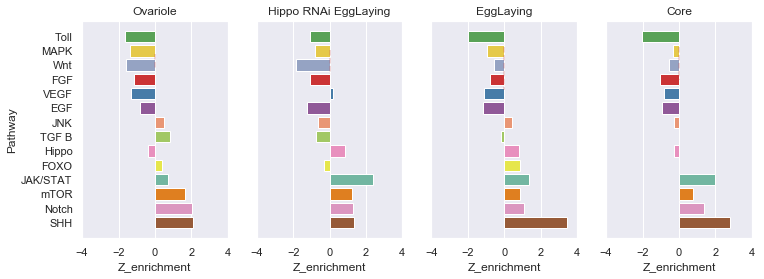

In [17]:
fig = plt.figure(figsize=(12,4))
i = 1
colors = []
for s in order:
    colors.append(colormap[s])
for module in modules:
    ax = fig.add_subplot(1,4,i)
    sns.barplot(data=enrichment[enrichment['Module'] == module], y='Pathway', x='Z_enrichment', palette=colors, order=order)
    plt.plot([0,0], [ax.get_xlim()[0]+3,ax.get_xlim()[1]], 'r--', alpha = 0.3)
    plt.title(module)
    if i != 1:
        plt.yticks([])
        plt.ylabel("")
    plt.xlim(-4,4)
    i+=1
fig.savefig(os.path.join(resultpath, 'Figures/Signaling_enrichment_modules_bootstrap_zscore.svg'))

## Calculating enrichment with HyperGeometric p-value 
from http://pedagogix-tagc.univ-mrs.fr/courses/ASG1/practicals/go_statistics_td/go_statistics_td_2015.html
and https://blog.alexlenail.me/understanding-and-implementing-the-hypergeometric-test-in-python-a7db688a7458

In [18]:
from scipy.stats import hypergeom

In [19]:
def CalculateHyperGeometricProbability(geneset, sigs, base=screen_genes):
    k = len(geneset) ## Size of the selection
    N = len(base) ## Total number of genes.
    proba = {}
    values = {}
    res = []
    for sig in sigs:
        # Number of "marked" elements, i.e. genes associated to this signaling pathway
        m = len(signaling[(signaling['FbID'].isin(base)) & (signaling['Sig'] == sig)]) 
        # Number of "non-marked" elements, i.e. genes not associated to this biological process
        n = N - m 
        # Number of "marked" elements in the selection, i.e. genes of the group of interest that are associated to this biological process
        x = len(signaling[(signaling['FbID'].isin(geneset)) & (signaling['Sig'] == sig)]) 
        # Calculate the Fold Enrichment
        fold_enrichment =  (x / k ) / (m / N)
        # Generate the PDF for each Hyper Geometric distributions
        X = np.arange(0, min(k, m))
        H = stats.hypergeom(n, m, k)
        p = H.pmf(X)
        
        proba[sig] = p
        values[sig] = x
        pval = H.sf(x-1)
        res.append([sig, fold_enrichment, pval])
    enrichment = pd.DataFrame(res, columns=['Pathway', 'Fold Enrichment', 'p-value'])
    return proba, values, enrichment

In [20]:
# Uncomment this code to see the hypergeometric distribution and the x value on each


# fig = plt.figure(figsize=(15,20))
# for module in modules:
#     genes = modules[module]
#     proba, values, enrichment = CalculateHyperGeometricProbability(genes, signaling['Sig'].unique())
#     i = 1
#     for sig in signaling['Sig'].unique():
#         ax = fig.add_subplot(5,3,i)
#         plt.plot(proba[sig])
#         plt.plot([values[sig]], [proba[sig][values[sig]]], 'ro')
#         plt.title("{}".format(sig))
#         i += 1

Ovariole
     Pathway  Fold Enrichment   p-value
0        FGF         0.482078  0.953654
1       VEGF         0.354469  0.962335
2       Toll         0.354469  0.991719
3        JNK         1.115921  0.533265
4        EGF         0.669553  0.944975
5       mTOR         1.506494  0.177411
6       FOXO         1.019780  0.754677
7        SHH         1.536033  0.126728
8      Hippo         0.817081  0.913126
9   JAK/STAT         1.205195  0.446641
10       Wnt         0.642112  0.999988
11     Notch         1.538547  0.131320
12     TGF B         1.158841  0.521111
13      MAPK         0.415584  0.977869
Hippo RNAi EggLaying
     Pathway  Fold Enrichment   p-value
0        FGF         0.488421  0.950899
1       VEGF         1.077399  0.574742
2       Toll         0.538700  0.960100
3        JNK         0.678363  0.880050
4        EGF         0.542690  0.979375
5       mTOR         1.356725  0.296469
6       FOXO         0.845344  0.913667
7        SHH         1.316821  0.324586
8      Hip

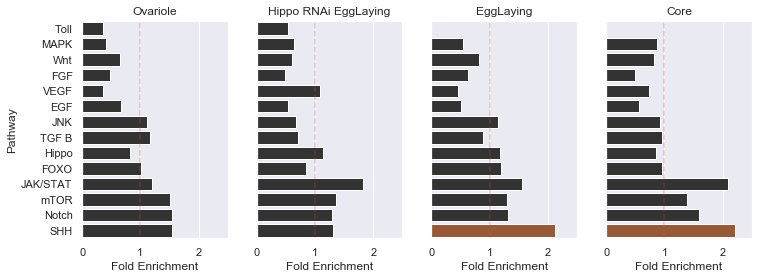

In [21]:
# Define our 4 modules
modules = {'Ovariole':ova_module, "Hippo RNAi EggLaying":fec_module, "EggLaying":xRNAi_module, "Core":core_module}
fig = plt.figure(figsize=(12,4))
i = 1
for module in modules:
    genes = modules[module]
    colors = []
    proba, values, enrichment = CalculateHyperGeometricProbability(genes, signaling['Sig'].unique())
    print(module)
    print(enrichment)
    for s in order:
        if enrichment[enrichment['Pathway'] == s]['p-value'].values[0] < 0.05:
            colors.append(colormap[s])
        else:
            colors.append((0.2,0.2,0.2))
    ax = fig.add_subplot(1,4,i)
    plt.plot([1,1],[-20, 20], 'r--', alpha=0.3)
    sns.barplot(data=enrichment, y='Pathway', x='Fold Enrichment', palette=colors, order=order)
    
    plt.title(module)
    if i != 1:
        plt.yticks([])
        plt.ylabel("")
    plt.xlim(0,2.5)
    i+=1
fig.savefig(os.path.join(resultpath, 'Figures/Signaling_enrichment_modules_HyperGeometric.svg'))

# Re doing the analysis but with the seeds instead

## Bootstrap analysis

In [22]:
modules = {'Ovariole':Zposneg_ova, "Hippo RNAi EggLaying":Zposneg_fec, "EggLaying":Zposneg_xRNAi}

In [23]:
# Define our result list
enrichment = []
# Iterate over all modules
for module in modules:
    print("Calculating Module:", module)
    # Calculate the random distribution of signaling networks
    dist, prob = Calculate_Bootsrap_Probability(len(modules[module]), signaling['Sig'].unique(), n_bootstrap=boostrapnb)
    module_counts = signaling[signaling['FbID'].isin(modules[module])].groupby('Sig',as_index=False).count()
    for sig in module_counts['Sig'].unique():
        c = module_counts[module_counts['Sig'] == sig]['CG'].values[0]
        Z = (c - np.mean(dist[sig])) / np.std(dist[sig])
        p = prob[sig][c]
        enrichment.append([module, sig, Z, p])
enrichment = pd.DataFrame(enrichment, columns=['Module','Pathway','Z_enrichment', 'Probability'])
toadd = []
for module in modules:
    for sig in signaling['Sig'].unique():
        if sig not in enrichment[enrichment['Module'] == module]['Pathway'].values:
            Z = (0 - np.mean(dist[sig])) / np.std(dist[sig])
            p = prob[sig][c]
            toadd.append([module,sig,Z, p])
toadd = pd.DataFrame(toadd, columns=['Module','Pathway','Z_enrichment', 'Probability'])
enrichment = enrichment.append(toadd)

  0% (19 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:01:47

Calculating Module: Ovariole


100% (10000 of 10000) |##################| Elapsed Time: 0:01:16 Time:  0:01:16
  0% (11 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:01:42

Calculating Module: Hippo RNAi EggLaying


100% (10000 of 10000) |##################| Elapsed Time: 0:01:09 Time:  0:01:09
  0% (26 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:38

Calculating Module: EggLaying


100% (10000 of 10000) |##################| Elapsed Time: 0:01:13 Time:  0:01:13


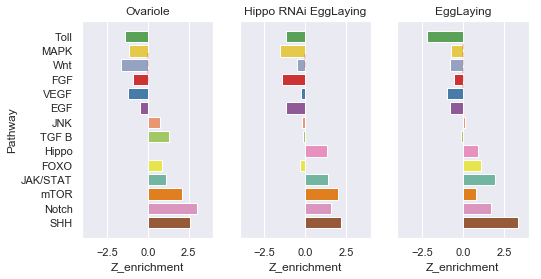

In [24]:
fig = plt.figure(figsize=(8,4))
i = 1
colors = []
for s in order:
    colors.append(colormap[s])
for module in modules:
    ax = fig.add_subplot(1,3,i)
    sns.barplot(data=enrichment[enrichment['Module'] == module], y='Pathway', x='Z_enrichment', palette=colors, order=order)
    plt.plot([0,0], [ax.get_xlim()[0]+3,ax.get_xlim()[1]], 'r--', alpha = 0.3)
    plt.title(module)
    if i != 1:
        plt.yticks([])
        plt.ylabel("")
    plt.xlim(-4,4)
    i+=1
fig.savefig(os.path.join(resultpath, 'Figures/Signaling_enrichment_bootstrap_zscore.svg'))

## HyperGeometric

Ovariole
     Pathway  Fold Enrichment   p-value
0        FGF         0.554030  0.918595
1       VEGF         0.407375  0.940138
2       Toll         0.407375  0.980690
3        JNK         1.282477  0.400195
4        EGF         0.769486  0.880775
5       mTOR         1.731343  0.089538
6       FOXO         1.171986  0.549038
7        SHH         1.765291  0.048139
8      Hippo         0.939034  0.801955
9   JAK/STAT         1.385075  0.310034
10       Wnt         0.624419  0.999968
11     Notch         1.915529  0.023055
12     TGF B         1.331803  0.327425
13      MAPK         0.477612  0.956055
Hippo RNAi EggLaying
     Pathway  Fold Enrichment   p-value
0        FGF         0.314576  0.975736
1       VEGF         0.925224  0.682291
2       Toll         0.462612  0.963160
3        JNK         0.873823  0.734567
4        EGF         0.524294  0.969281
5       mTOR         1.747646  0.103939
6       FOXO         0.846936  0.885810
7        SHH         1.696245  0.088800
8      Hip

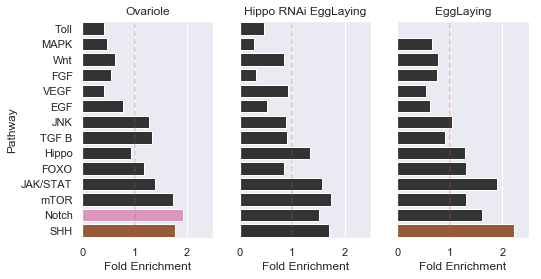

In [25]:
# Define our 4 modules
fig = plt.figure(figsize=(8,4))
i = 1
for module in modules:
    genes = modules[module]
    colors = []
    proba, values, enrichment = CalculateHyperGeometricProbability(genes, signaling['Sig'].unique())
    print(module)
    print(enrichment)
    for s in order:
        if enrichment[enrichment['Pathway'] == s]['p-value'].values[0] < 0.05:
            colors.append(colormap[s])
        else:
            colors.append((0.2,0.2,0.2))
    ax = fig.add_subplot(1,3,i)
    plt.plot([1,1],[-20, 20], 'r--', alpha=0.3)
    sns.barplot(data=enrichment, y='Pathway', x='Fold Enrichment', palette=colors, order=order)
    
    plt.title(module)
    if i != 1:
        plt.yticks([])
        plt.ylabel("")
    plt.xlim(0,2.5)
    i+=1
fig.savefig(os.path.join(resultpath, 'Figures/Signaling_enrichment_HyperGeometric.svg'))

## Rerunning the analysis with only the 273 candiate post first screen

In [26]:
assert(len(mean_ova_gene['FbID'].unique()) == 273)

AssertionError: 

In [ ]:
modules = {'Ovariole':Zposneg_ova, 'Selected Candidates':mean_ova_gene['FbID'].unique(), "EggLaying":Zposneg_xRNAi}

### Bootstrap analysis

In [ ]:
module = "Selected Candidates"

In [ ]:
module_counts = signaling[signaling['FbID'].isin(modules[module])].groupby('Sig',as_index=False).count()

In [ ]:
# Define our 4 modules
fig = plt.figure(figsize=(12,4))
i = 1
for module in modules:
    genes = modules[module]
    colors = []
    if module != "Selected Candidates":
        proba, values, enrichment = CalculateHyperGeometricProbability(genes, signaling['Sig'].unique(), base=mean_ova_gene['FbID'].unique())
    else:
        proba, values, enrichment = CalculateHyperGeometricProbability(genes, signaling['Sig'].unique())
    print(module)
    print(enrichment)
    for s in order:
        if enrichment[enrichment['Pathway'] == s]['p-value'].values[0] < 0.05:
            colors.append(colormap[s])
        else:
            colors.append((0.2,0.2,0.2))
    ax = fig.add_subplot(1,3,i)
    plt.plot([1,1],[-20, 20], 'r--', alpha=0.3)
    sns.barplot(data=enrichment, y='Pathway', x='Fold Enrichment', palette=colors, order=order)
    
    plt.title(module)
    if i != 1:
        plt.yticks([])
        plt.ylabel("")
    plt.xlim(0,2.5)
    i+=1
fig.savefig(os.path.join(resultpath, 'Figures/Signaling_enrichment_HyperGeometric_Normed.svg'))

# Epistasy between pathways and Hippo analysis

In [ ]:
fig = plt.figure(figsize=(10,17))
i = 1
for sig in signaling['Sig'].unique():
    ax = fig.add_subplot(5,3,i)
    color = colormap[sig]
    # Select the genes that belong to signaling pathway sig, and are in xRNAi
    xRNAi = mean_xRNAi_gene[mean_xRNAi_gene['FbID'].isin(signaling[signaling['Sig'] == sig]['FbID'].values)]['Z'].values
    # Select the genes that are common to xRNAi and are member of sig
    fec = mean_fec_gene[mean_fec_gene['FbID'].isin(mean_xRNAi_gene[mean_xRNAi_gene['FbID'].isin(signaling[signaling['Sig'] == sig]['FbID'].values)]['FbID'].values)]['Z'].values
    
    # Plot the Kernel density estimate
    ax = sns.kdeplot(xRNAi, fec, n_levels=2)
    # Needed to make the color right because seaborn just can't handle it somehow ...
    l = ax.get_children()[0]
    l.set_color(colormap[sig])
    l = ax.get_children()[1]
    l.set_color(colormap[sig])
    
    # Plot the scatter plot of each datapoint 
    color = colormap[sig]
    ax.scatter(xRNAi, fec, c=color, alpha=0.7, label=sig)
    ax.plot([-15,15],[-15,15],'r--', alpha=0.3)
    if i == 7:
        ax.set_ylabel('Hippo RNAi Egg Laying Zscore')
    if i == 14:
        ax.set_xlabel('Egg Laying Zscore')
    ax.set_title(sig)
    i += 1
    plt.xlim(-12,12)
    plt.ylim(-12,12)
fig.savefig(os.path.join(resultpath, 'Figures/HippoEpistasy_Signaling_KDE.svg'))

In [ ]:
fig.savefig(os.path.join(resultpath, 'Figures/HippoEpistasy_Signaling_KDE.svg'))